In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy.fftpack import fft, fftfreq
import scipy as sp

#import betterplot

from scipy import signal

import umap
import umap.plot



/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dokhtdor/.conda/envs/test_imag/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
freqmin = 1
freqmax = 8
sr = 40

reduce_type = np.mean

name_fig = 'figure03'

name = f"final_version/{name_fig}"

savepath = f"/bettik/dokhtdor/projects/mirko_volcano_simulations/figures/{name}/"

os.makedirs(savepath, exist_ok=True)



In [3]:


FILEPATH = "/bettik/dokhtdor/projects/mirko_volcano_simulations/dataset/"

vs = np.load(FILEPATH + 'vs_array.npy') 

data_s1 = np.hstack([np.load(FILEPATH + "z_r1.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r1.npy")[:, np.newaxis,:]] )
data_s2 = np.hstack([np.load(FILEPATH + "z_r2.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r2.npy")[:, np.newaxis,:]] )
data_s3 = np.hstack([np.load(FILEPATH + "z_r_s3.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s3.npy")[:, np.newaxis,:]] )
data_s4 = np.hstack([np.load(FILEPATH + "z_r_s4.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s4.npy")[:, np.newaxis,:]] )
data_s5 = np.hstack([np.load(FILEPATH + "z_r_s5.npy")[:, np.newaxis,:], np.load(FILEPATH + "x_r_s5.npy")[:, np.newaxis,:]] )

# Concatenating the sources 
data = np.concatenate([data_s1, data_s2, data_s3, data_s4, data_s5], axis = 1) #+ 

# Filtering the data
#datafilter = filter(data[:, :], freqmin = freqmin, freqmax = freqmax, fs = 40, order = 2)



from scipy.signal import butter, sosfiltfilt

sos = butter(10, [freqmin, freqmax], 'bandpass', fs=sr, output='sos')
datafilter = sosfiltfilt(sos, data[:,:,:], axis=-1)


datafilter = data[:, : ,:]#[:, np.newaxis, :]

#norm_two_channel  = np.sqrt(np.linalg.norm((data[:,:,:]), axis =2, keepdims=True)[:, 0, :]**2 + np.linalg.norm((data[:,:,:]), axis =2, keepdims=True)[:, 0, :]**2 )

# Normalizing the data

#data = datafilter

data = datafilter[:,:,::1] / np.linalg.norm(abs(datafilter[:, :, :]), ord = 2, axis = -1, keepdims=True)
#data = datafilter[:,:,::1] / np.max(abs(datafilter[:, :, :]),  axis = -1, keepdims=True)

#data  = data[:,:,::1] = data/ np.max(abs(data))




In [4]:


from scatseisnet import ScatteringNetwork

segment_duration_seconds = data.shape[-1]/sr

sampling_rate_hertz = sr

samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)


bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 10, "quality": 2, "taper_alpha" : 0.},
    {"octaves": 6 , "resolution": 5, "quality": 2, "taper_alpha" : 0.},
     )


network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )

print(network)



ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=10, quality=2, sampling_rate=40, len=40)
ComplexMorletBank(bins=1500, octaves=6, resolution=5, quality=2, sampling_rate=40, len=30)


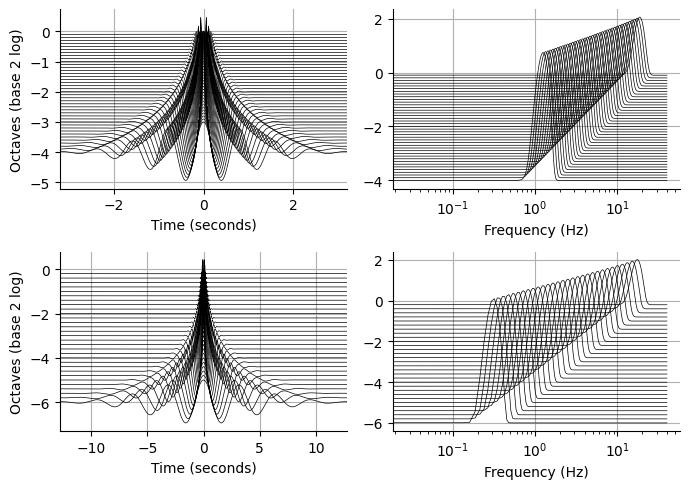

In [5]:

# Loop over network layers
#plt.figure(figsize=(10,5))

#cc = low_pass_filter(2000, sigma = 0.2)
fig, ax = plt.subplots(2, 2, figsize=(7,5),  )


for i, bank in enumerate(network.banks):

    # Create axes (left for temporal, right for spectral domain)
    
    ii = 0
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
    ):

        # Time domain
        ax[i,0].plot(bank.times, wavelet.real + ratio, c= 'k', lw = 0.5)
        #ax[i,0].plot(bank.times, wavelet.imag + ratio, c='r', lw = 0.5)

        # Spectral domain (log of amplitude)
        ax[i,1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, c = 'k', lw = 0.5)
        #ax[i,2].plot(bank.frequencies, np.log(np.abs(spectrum*cc[1000:]) + 1) + ratio, c = 'b', lw = 0.5)
        
    #ax[0,1].plot(bank.frequencies, np.log(np.abs(cc[1000:]) + 1) -0.25, c = 'r', lw = 0.5)

    # Limit view to three times the temporal width of largest wavelet
    width_max = 2 * bank.widths.max()

    # Labels
    
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()

    #ax[i, 0].set_xlim(0.1, 50)
    #  
    #ax[i,2].set_xscale("log")
    #ax[i,2].set_xlabel("Frequency (Hz)")
    #ax[i,2].grid()
    #ax[i, 1].set_xlim(0.1, 50)
    
    ii = ii+1

for axn in ax.flat:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)


    
fig.tight_layout()
fig.savefig(savepath + f'filterbank.pdf', transparent=True, dpi = 300)


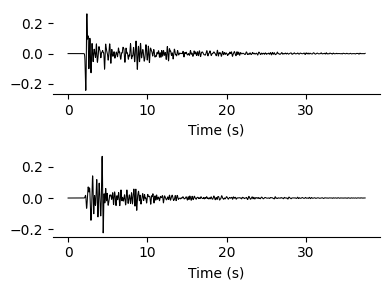

In [6]:

time = np.arange(0, data.shape[-1], 1) / sr
indxvs = np.arange(120*65).reshape(120, 65)

indx = [15, 35, 55, 75, 95]


fig, axs = plt.subplots(2, 1, figsize = (4, 3))

axs[0].plot(time, data[indxvs[75, 30], 0, :].T,lw = 0.75, c = 'k')

axs[1].plot(time, data[indxvs[75, 30], 1, :].T,lw = 0.75, c = 'k')


ax = axs[0]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Time (s)')

ax = axs[1]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlabel('Time (s)')

fig.tight_layout()
fig.savefig(savepath + f'seismograms.pdf', transparent=True)



In [7]:


from scatseisnet import ScatteringNetwork

segment_duration_seconds = data.shape[-1]/sr

sampling_rate_hertz = sr

samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)

bank_keyword_arguments = (
    {"octaves": 4 , "resolution": 6, "quality": 3, "taper_alpha" : 0.},
    {"octaves": 7 , "resolution": 2, "quality": 1, "taper_alpha" : 0.},
    )


network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
    )

print(network)




ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=6, quality=3, sampling_rate=40, len=24)
ComplexMorletBank(bins=1500, octaves=7, resolution=2, quality=1, sampling_rate=40, len=14)


In [8]:
segments = [data[i,:,:] for i in indxvs[indx, 30]]


sc1 = network.transform(segments,  reduce_type= None )



In [9]:
sc1[0][3, 0].shape, time.shape, network.banks[0].centers.shape

((24, 1500), (1500,), (24,))

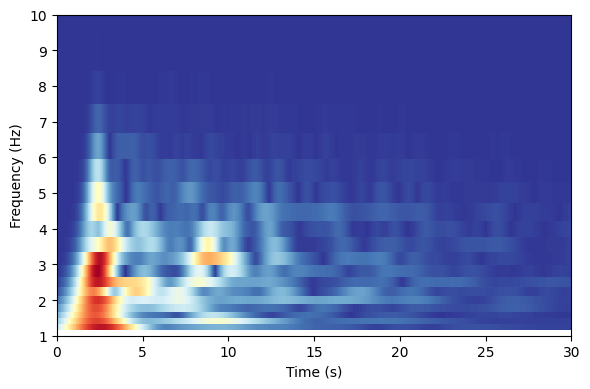

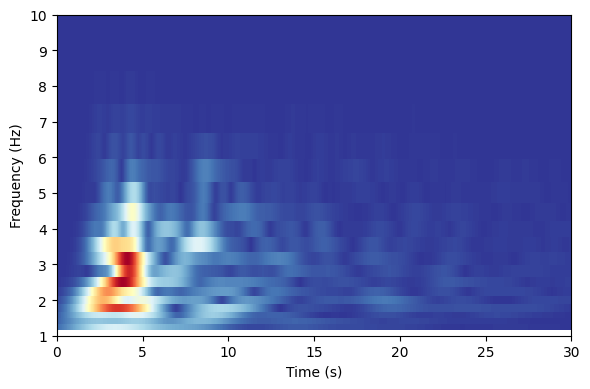

In [10]:
plt.figure(figsize=(6,4))  
plt.pcolormesh(time, network.banks[0].centers, np.abs(sc1[0][3, 0]), cmap = 'RdYlBu_r', rasterized = True)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(1, 10)
plt.xlim(0, 30)
plt.tight_layout()

plt.savefig(savepath + f'sc1.pdf', transparent=True, dpi = 100)


plt.figure(figsize=(6,4))  
plt.pcolormesh(time, network.banks[0].centers, np.abs(sc1[0][3, 1]), cmap = 'RdYlBu_r', rasterized = True)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(1, 10)
plt.xlim(0, 30)

plt.tight_layout()
plt.savefig(savepath + f'sc1_2.pdf', transparent=True, dpi = 100)



In [11]:
sc1[i][3, 0, i].shape

(14, 1500)

/tmp/ipykernel_1105237/2826582251.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,4))


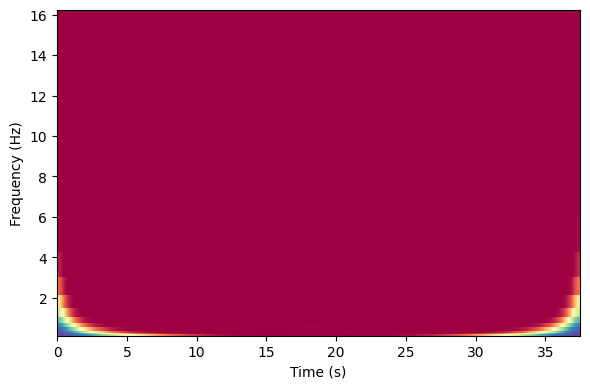

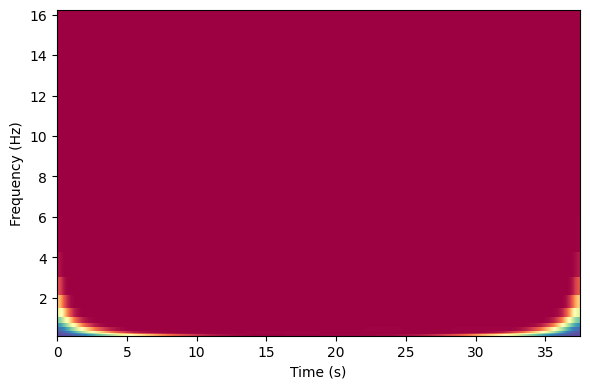

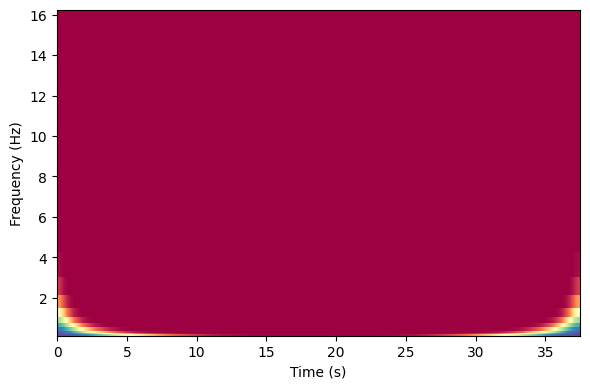

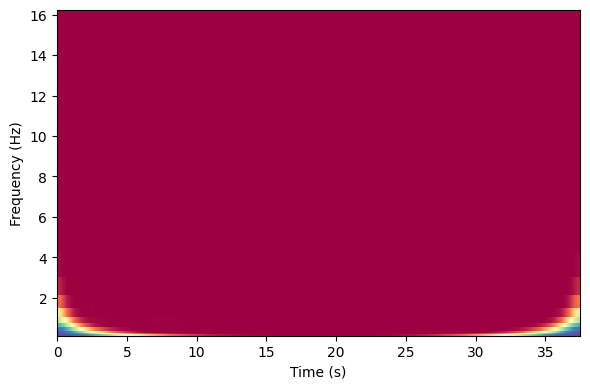

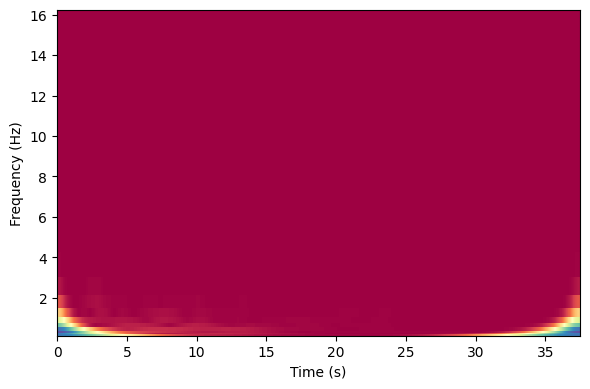

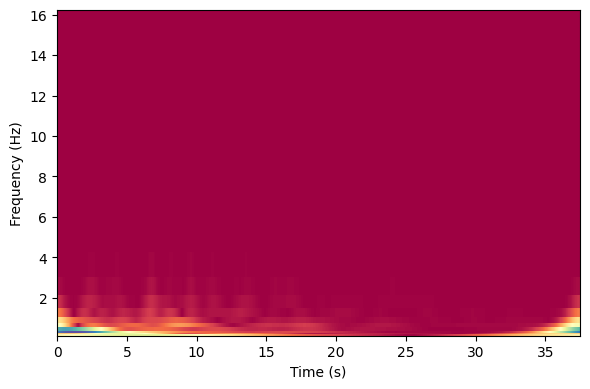

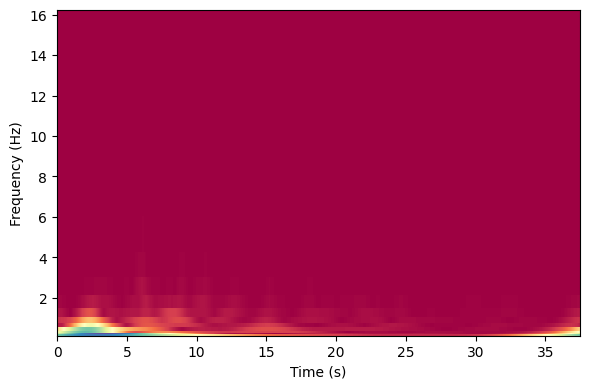

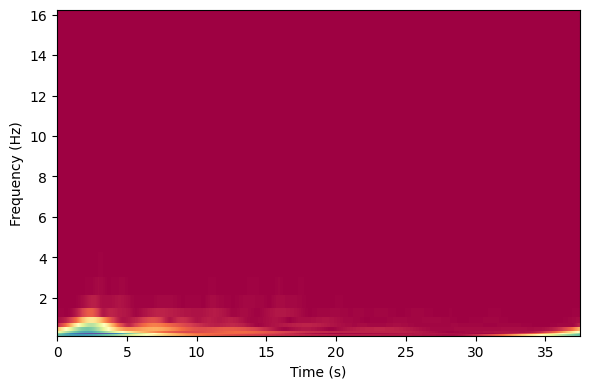

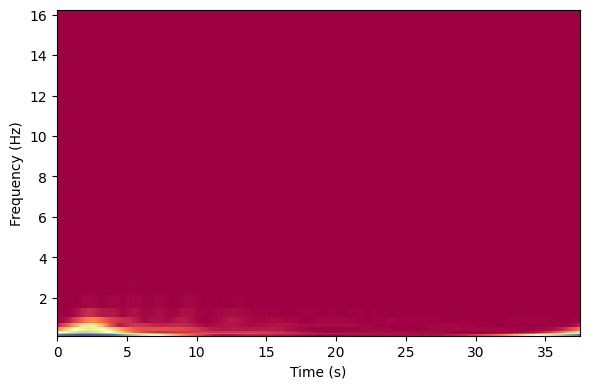

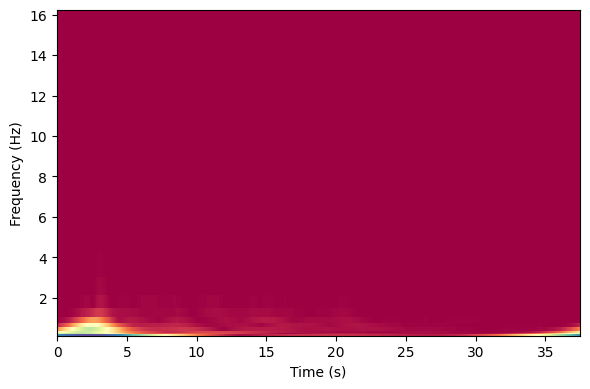

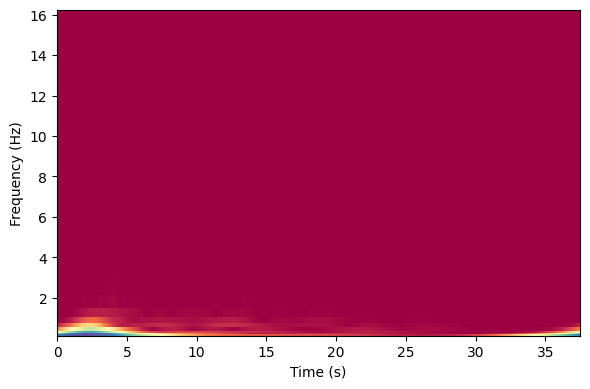

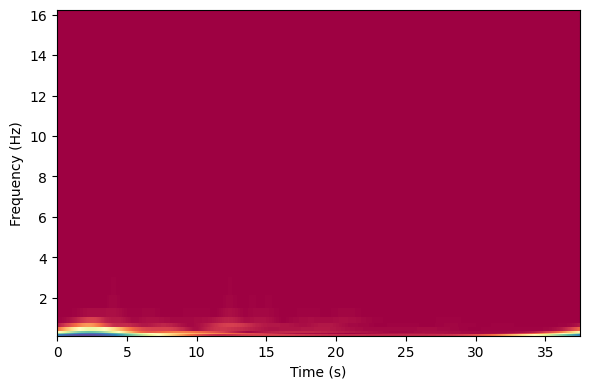

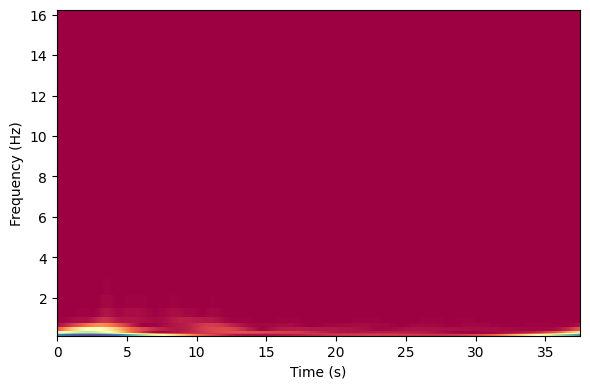

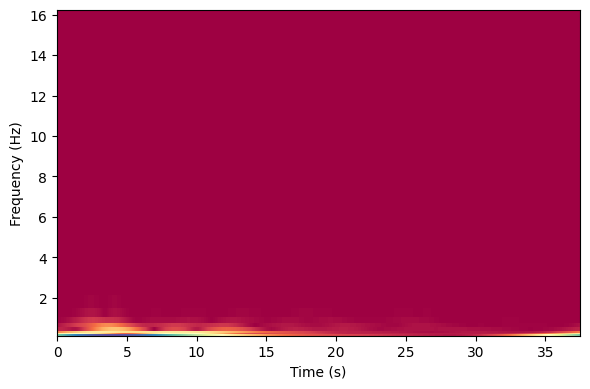

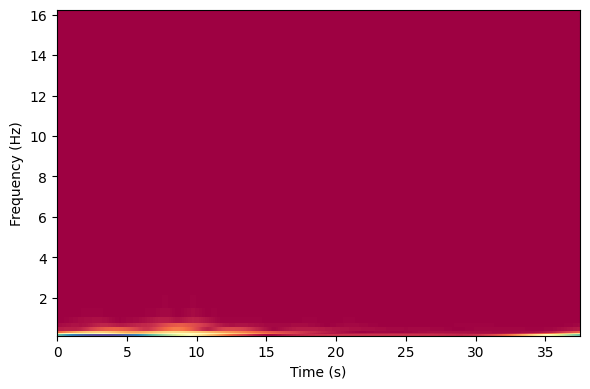

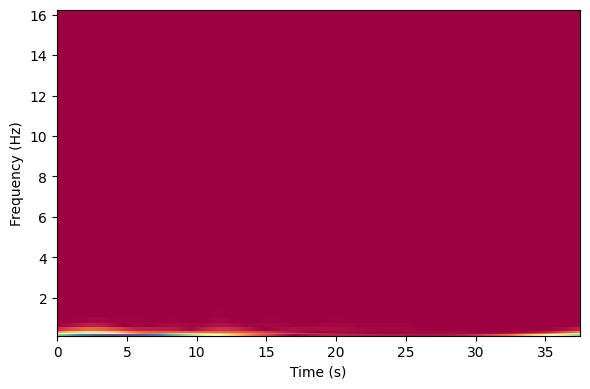

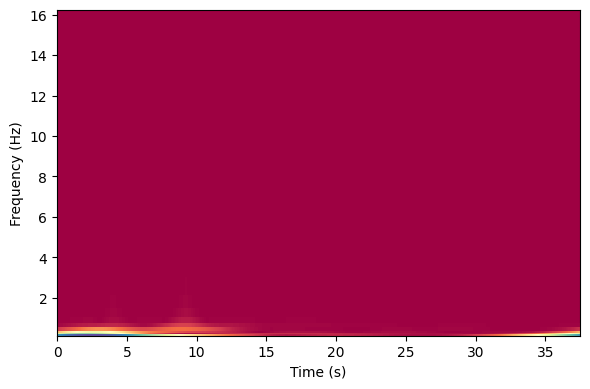

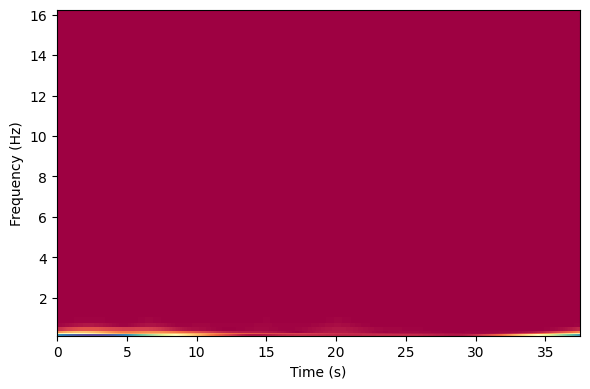

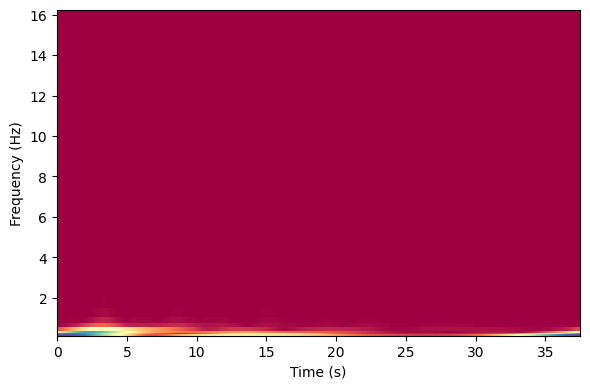

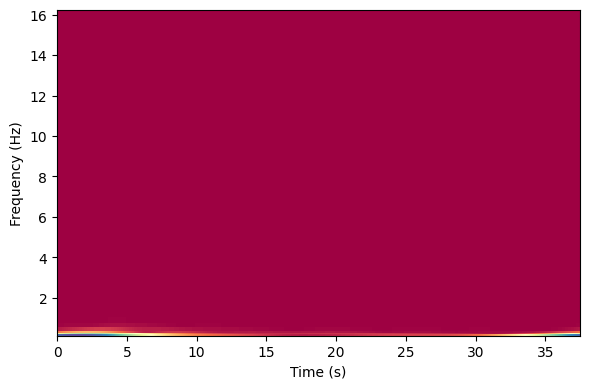

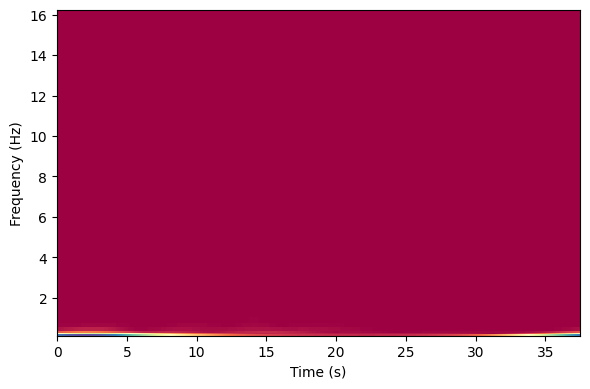

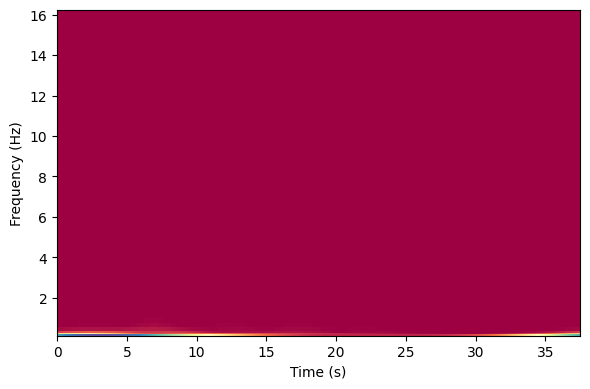

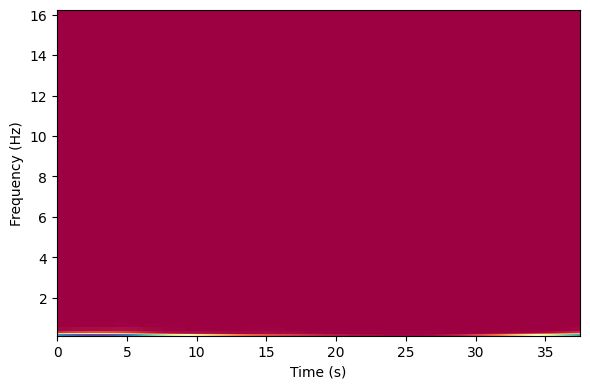

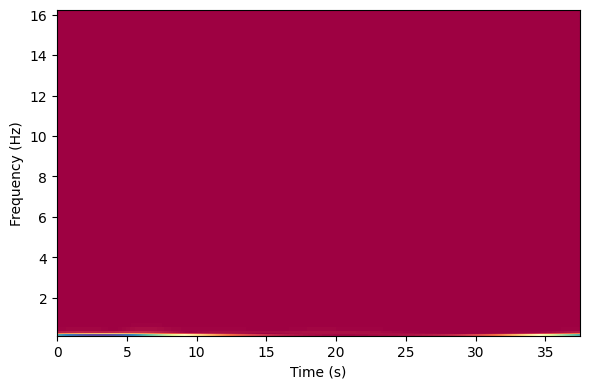

In [12]:

for i in range(24):
        
    plt.figure(figsize=(6,4))  
    plt.pcolormesh(time, network.banks[1].centers, np.abs(sc1[1][3, 0, i]), cmap = 'Spectral', rasterized = True)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(savepath + f'sc2_{i}_{network.banks[0].centers[i]}.pdf', transparent=True, dpi = 300)

